## Building our own data Pipe lines 

In [185]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import numpy as np
from math import pi
import os
from math import pi
from urllib.request import urlopen
import matplotlib.patheffects as pe
from highlight_text import fig_text
from adjustText import adjust_text

import unicodedata
from fuzzywuzzy import fuzz
from fuzzywuzzy import process


In [191]:
def fuzzy_merge(df_1, df_2, key1, key2, threshold=97, limit=1):
    """
    :param df_1: the left table to join
    :param df_2: the right table to join
    :param key1: key column of the left table
    :param key2: key column of the right table
    :param threshold: how close the matches should be to return a match, based on Levenshtein distance
    :param limit: the amount of matches that will get returned, these are sorted high to low
    :return: dataframe with boths keys and matches
    """
    s = df_2[key2].tolist()
    
    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    df_1['matches'] = m
    
    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['matches'] = m2
    
    return df_1

In [192]:
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    only_ascii = str(only_ascii)
    only_ascii = only_ascii[2:-1]
    only_ascii = only_ascii.replace('-', ' ')
    return only_ascii


In [237]:
def get_team_urls(x):  
    url = x
    data  = requests.get(url).text
    soup = BeautifulSoup(data)
    player_urls = []
    links = BeautifulSoup(data).select('th a')
    urls = [link['href'] for link in links]
    urls = list(set(urls))
    full_urls = []
    for y in urls:
        full_url = "https://fbref.com"+y
        full_urls.append(full_url)
    team_names = []
    for team in urls: 
        team_name_slice = team[20:-6]
        team_names.append(team_name_slice)
    list_of_tuples = list(zip(team_names, full_urls))
    Team_url_database = pd.DataFrame(list_of_tuples, columns = ['team_names', 'urls'])
    return Team_url_database


In [242]:
team_urls = get_team_urls("https://fbref.com/en/comps/9/Premier-League-Stats")  
full_urls = list(team_urls.urls.unique())

In [235]:
def general_url_database(full_urls):    
    appended_data = []
    for team_url in full_urls:
        url = team_url
        # print(url)
        player_db = pd.DataFrame()
        player_urls = []
        data  = requests.get(url).text
        links = BeautifulSoup(data).select('th a')
        urls = [link['href'] for link in links]
        player_urls.append(urls)
        player_urls  = [item for sublist in player_urls  for item in sublist]
        player_urls.sort()
        player_urls = list(set(player_urls))
        p_url = list(filter(lambda k: 'players' in k, player_urls))
        url_final = []
        for y in p_url:
            full_url = "https://fbref.com"+y
            url_final.append(full_url)
        player_names = []
        for player in p_url: 
            player_name_slice = player[21:]
            player_name_slice = player_name_slice.replace('-', ' ')
            player_names.append(player_name_slice)
        # player_names
        list_of_tuples = list(zip(player_names, url_final))
        play_url_database = pd.DataFrame(list_of_tuples, columns = ['Player', 'urls'])
        player_db = pd.concat([play_url_database])

        html = requests.get(url).text
        data2 = BeautifulSoup(html, 'html5')
        table = data2.find('table')
        cols = []

        for header in table.find_all('th'):
            cols.append(header.string)

        columns = cols[8:37] #gets necessary column headers
        players = cols[37:-2]

        #display(columns)
        rows = [] #initliaze list to store all rows of data
        for rownum, row in enumerate(table.find_all('tr')): #find all rows in table
            if len(row.find_all('td')) > 0: 
                rowdata = [] #initiliaze list of row data
                for i in range(0,len(row.find_all('td'))): #get all column values for row
                    rowdata.append(row.find_all('td')[i].text)
                rows.append(rowdata)
        df = pd.DataFrame(rows, columns=columns)

        df.drop(df.tail(2).index,inplace=True)
        df["Player"] = players
        df = df[["Player","Pos","Age", "Starts"]]

        df['Player'] = df.apply(lambda x: remove_accents(x['Player']), axis=1)
        test_merge = fuzzy_merge(df, player_db, 'Player', 'Player', threshold=90)
        test_merge = test_merge.rename(columns={'matches': 'Player', 'Player': 'matches'})
        # test_merge = test_merge.drop(columns=['matches'])
        final_merge = test_merge.merge(player_db, on='Player', how='left')
        # list_of_dfs.append(final_merge)
        appended_data.append(final_merge)
    appended_data = pd.concat(appended_data)
    return appended_data 

In [254]:
EPL_Player_db = general_url_database(full_urls)

In [255]:
def years_converter(variable_value):
    years = variable_value[:-4]
    days = variable_value[3:]
    years_value = pd.to_numeric(years)
    days_value = pd.to_numeric(days)
    day_conv = days_value/365
    final_val = years_value + day_conv

    return final_val

EPL_Player_db['Age'] = EPL_Player_db.apply(lambda x: years_converter(x['Age']), axis=1)
EPL_Player_db = EPL_Player_db.drop(columns=['matches'])

In [258]:
EPL_Player_db.Pos.unique()

array(['DF', 'MF', 'FW', 'GK', 'FW,MF', 'MF,DF', 'MF,FW', 'DF,FW',
       'DF,MF', 'FW,DF'], dtype=object)

In [259]:
keepers = ['GK']
defenders = ["DF",'DF,MF']
wing_backs = ['FW,DF','DF,FW']
defensive_mids = ['MF,DF']
midfielders = ['MF']
attacking_mids = ['MF,FW',"FW,MF"]
forwards = ['FW']
def position_grouping(x):
    if x in keepers:
        return "GK"
    elif x in defenders:
        return "Defender"
    elif x in wing_backs:
        return "Wing-Back"
    elif x in defensive_mids:
        return "Defensive-Midfielders"
    elif x in midfielders:
        return "Central Midfielders"
    elif x in attacking_mids:
        return "Attacking Midfielders"
    elif x in forwards:
        return "Forwards"
    else:
        return "unidentified position"

EPL_Player_db["position_group"] = EPL_Player_db.Pos.apply(lambda x: position_grouping(x))


In [263]:
EPL_Player_db.reset_index(drop=True)
EPL_Player_db[["Starts"]] = EPL_Player_db[["Starts"]].apply(pd.to_numeric) 

In [265]:
position = 'Central Midfielders'
pl_starts = 10
max_age = 26

In [266]:
subset_of_data = EPL_Player_db.query('position_group == @position & Starts > @pl_starts & Age < @max_age' )

In [267]:
subset_of_data

,Pos,Age,Starts,Player,urls,position_group
7,MF,23.849315,20,Vitaly Janelt,https://fbref.com/en/players/8449d35e/Vitaly-J...,Central Midfielders
12,MF,24.202740,12,Frank Onyeka,https://fbref.com/en/players/2944f86f/Frank-On...,Central Midfielders
5,MF,23.852055,23,Douglas Luiz,https://fbref.com/en/players/6f7d826d/Douglas-...,Central Midfielders
7,MF,20.800000,22,Jacob Ramsey,https://fbref.com/en/players/1544f145/Jacob-Ra...,Central Midfielders
2,MF,22.104110,25,Conor Gallagher,https://fbref.com/en/players/c2731c10/Conor-Ga...,Central Midfielders
10,MF,22.873973,12,Imran Louza,https://fbref.com/en/players/e1df6989/Imran-Louza,Central Midfielders
4,MF,25.731507,24,Rodri,https://fbref.com/en/players/6434f10d/Rodri,Central Midfielders
2,MF,22.569863,20,Joe Willock,https://fbref.com/en/players/a3b03921/Joe-Willock,Central Midfielders
15,MF,24.375342,11,Sean Longstaff,https://fbref.com/en/players/a2b105e0/Sean-Lon...,Central Midfielders
3,MF,25.268493,22,Scott McTominay,https://fbref.com/en/players/d93c2511/Scott-Mc...,Central Midfielders


In [269]:
players_needed = list(subset_of_data.urls.unique())

In [270]:
def get_player_multi_data(url_list:list):
    appended_data = []
    for url in url_list:
        warnings.filterwarnings("ignore")
        page =requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        name = [element.text for element in soup.find_all("span")]
        name = name[7]
        metric_names = []
        metric_values = []
        remove_content = ["'", "[", "]", ","]
        for row in soup.findAll('table')[0].tbody.findAll('tr'):
            first_column = row.findAll('th')[0].contents
            metric_names.append(first_column)
        for row in soup.findAll('table')[0].tbody.findAll('tr'):
            first_column = row.findAll('td')[0].contents
            metric_values.append(first_column)

        metric_names = [item for sublist in metric_names for item in sublist]
        metric_values = [item for sublist in metric_values for item in sublist]

        df_player = pd.DataFrame()
        df_player['Name'] = name[0]
        for item in metric_names:
            df_player[item] = []

        name = name
        non_penalty_goals = (metric_values[0])
        npx_g = metric_values[1]
        shots_total = metric_values[2]
        assists = metric_values[3]
        x_a = metric_values[4]
        npx_g_plus_x_a = metric_values[5] 
        shot_creating_actions = metric_values[6] 
        passes_attempted = metric_values[7] 
        pass_completion_percent = metric_values[8] 
        progressive_passes = metric_values[9] 
        progressive_carries = metric_values[10] 
        dribbles_completed = metric_values[11] 
        touches_att_pen = metric_values[12]
        progressive_passes_rec = metric_values[13] 
        pressures = metric_values[14] 
        tackles = metric_values[15] 
        interceptions = metric_values[16] 
        blocks = metric_values[17]
        clearances = metric_values[18]
        aerials_won = metric_values[19]
        df_player.loc[0] = [name, non_penalty_goals, npx_g, shots_total, assists, x_a, npx_g_plus_x_a, shot_creating_actions, passes_attempted, pass_completion_percent,
                            progressive_passes, progressive_carries, dribbles_completed, touches_att_pen, progressive_passes_rec, pressures, tackles, interceptions, blocks,
                            clearances, aerials_won]
        appended_data.append(df_player)
    appended_data = pd.concat(appended_data)
    return appended_data

In [273]:
df = get_player_multi_data(players_needed)

In [283]:
df

,Name,Non-Penalty Goals,npxG,Shots Total,Assists,xA,npxG+xA,Shot-Creating Actions,Passes Attempted,Pass Completion %,...,Touches (Att Pen),Progressive Passes Rec,Pressures,Tackles,Interceptions,Blocks,Clearances,Aerials won,Progressive_Actions_p90,Passes_Attempted
0,Vitaly Janelt,0.10,0.10,1.10,0.00,0.08,0.18,1.83,38.38,74.9%,...,1.46,1.77,17.78,2.24,1.77,2.09,1.51,1.56,6.47,4.12
0,Frank Onyeka,0.00,0.09,1.38,0.00,0.02,0.11,1.46,28.25,79.6%,...,1.55,2.58,21.79,2.58,1.29,1.72,1.12,1.29,4.90,1.89
0,Douglas Luiz,0.03,0.05,0.75,0.10,0.08,0.13,2.00,46.52,83.4%,...,0.46,1.02,20.16,2.16,1.93,1.41,1.15,1.18,5.97,3.18
0,Jacob Ramsey,0.26,0.15,1.46,0.04,0.09,0.23,2.15,36.27,85.1%,...,2.27,3.30,20.82,2.53,1.33,1.59,1.07,0.94,9.14,3.35
0,Conor Gallagher,0.26,0.18,1.47,0.10,0.13,0.31,2.87,35.75,75.5%,...,2.77,3.62,26.03,2.58,1.44,1.79,1.04,1.04,4.89,1.86
0,Imran Louza,0.05,0.05,1.00,0.05,0.06,0.12,1.89,48.88,78.6%,...,0.79,1.26,23.42,2.57,2.83,1.20,1.10,0.79,6.28,3.61
0,Rodri,0.10,0.06,0.98,0.05,0.04,0.10,2.48,88.60,92.9%,...,1.76,2.02,15.70,2.20,1.73,1.40,1.94,2.56,11.77,5.51
0,Joe Willock,0.38,0.20,1.66,0.00,0.04,0.24,2.13,23.61,80.2%,...,3.28,2.98,24.20,2.93,1.57,2.13,0.77,0.68,5.40,1.74
0,Sean Longstaff,0.05,0.10,1.07,0.11,0.07,0.17,1.49,36.19,78.3%,...,1.07,1.33,27.28,3.15,1.33,1.71,1.39,1.01,3.31,2.14
0,Scott McTominay,0.03,0.07,1.04,0.06,0.06,0.12,1.52,49.36,86.3%,...,1.38,1.21,16.63,2.54,2.34,1.81,2.34,2.49,9.38,4.49


In [310]:
def squad_age_profile_chart(df, max_age, position):
        
        df[['Progressive Passes', 'Progressive Carries','Passes Attempted']] =  df[['Progressive Passes','Progressive Carries','Passes Attempted']].apply(pd.to_numeric)         
        df["Progressive_Actions_p90"] = df['Progressive Passes'] + df['Progressive Carries']
        df["Passes_Attempted"] = df['Passes Attempted']



        line_color = "silver"
       
        fig, ax = plt.subplots(figsize=(12, 8)) 

        ax.scatter(df["Progressive_Actions_p90"], df["Passes_Attempted"],alpha=0.8) ##scatter points
        ax.axvspan(10.0, 14.0, ymin=0.5, ymax=1, alpha=0.1, color='green',label= "In Form")

        texts = [] ##plot player names
        for row in df.itertuples():
                texts.append(ax.text(row.Progressive_Actions_p90, row.Passes_Attempted, row.Name, fontsize=8, ha='center', va='center', zorder=10))
                adjust_text(texts) ## to remove overlaps between labels

        ## update plot
                ax.set(xlabel="Progressive Action per 90", ylabel="Passes Attempted per 90", ylim=((df["Passes_Attempted"].min()-2), (df["Passes_Attempted"].max()+2)), xlim=((df["Progressive_Actions_p90"].min()-2), (df["Progressive_Actions_p90"].max()+2))) ## set labels and limits

        ##grids and spines
        ax.grid(color=line_color, linestyle='--', linewidth=0.8, alpha=0.5)   
        for spine in ["top", "right"]:
                ax.spines[spine].set_visible(False)
                ax.spines[spine].set_color(line_color)

        ax.xaxis.label.set(fontsize=12, fontweight='bold')
        ax.yaxis.label.set(fontsize=12, fontweight='bold') ## increase the weight of the axis labels

        ax.set_position([0.05, 0.05, 0.82, 0.78]) ## make space for the title on top of the axes

        ## title and subtitle
        fig.text(x=0.08, y=0.92, s=f"U-{max_age} {position} | Progressive Actions Profile", 
                ha='left', fontsize=20, fontweight='book', 
                path_effects=[pe.Stroke(linewidth=3, foreground='0.15'),
                        pe.Normal()]) 
        fig.text(x=0.08, y=0.88, s=f"EPL | 2021-22", ha='left', 
                fontsize=20, fontweight='book', 
                path_effects=[pe.Stroke(linewidth=3, foreground='0.15'),
                        pe.Normal()])

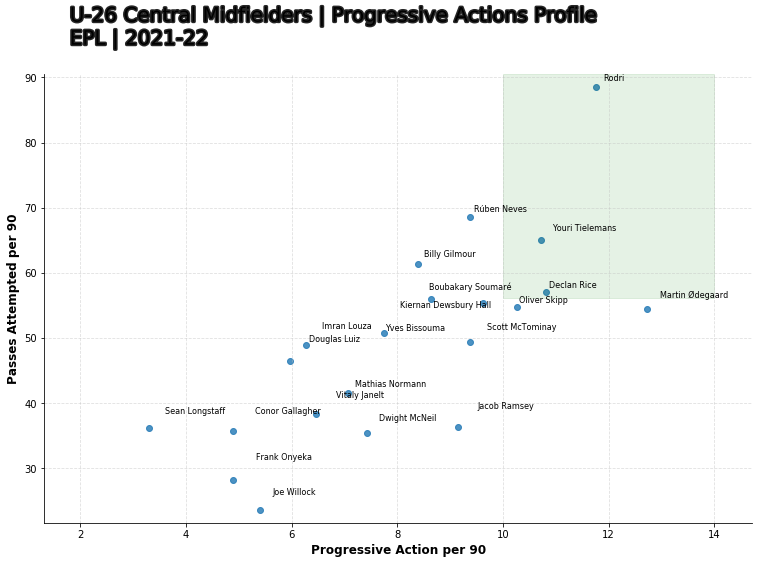

In [311]:
squad_age_profile_chart(df, max_age, position)

In [453]:
warnings.filterwarnings("ignore")
page =requests.get("https://fbref.com/en/players/de112b84/scout/365_euro/Jacob-Murphy-Scouting-Report")
soup = BeautifulSoup(page.content, 'html.parser')
name = [element.text for element in soup.find_all("span")]
name = name[7]
metric_names = []
metric_values = []
remove_content = ["'", "[", "]", ","]
for row in soup.findAll('table')[0].tbody.findAll('tr'):
    first_column = row.findAll('th')[0].contents
    metric_names.append(first_column)


metric_names = [item for sublist in metric_names for item in sublist]


In [454]:
for row in soup.findAll('table')[0].tbody.findAll('tr'):
    first_column = row.findAll('td')
    # [0].contents
    # print(len(first_column))
    # print(row)
    metric_values.append(first_column)

In [455]:
clean_left = []
splitat_r = 23
splitat_l = 28

for item in metric_values:
    item = str(item).strip('[]')
    # print(item)
    left, right = item[:splitat_l], item[splitat_r:]
    clean_left.append(left)


clean_overall= []

for item in clean_left:
    item = str(item).strip('[]')
    left, right = item[:splitat_l], item[splitat_r:]
    clean_overall.append(right)

clean = []

for item in clean_overall:
    item = item.replace("<","")
    clean.append(item)
metric_values = [item for sublist in metric_values for item in sublist]
metric_values
data = []
for item in clean:
    if item == "ta-st":
        clean.remove(item)
    elif item == 'k="0.':
        clean.remove(item)
    else:
        data.append(item)

df_player = pd.DataFrame()

df_player['Name'] = name[0]
for item in metric_names:
    df_player[item] = []

data.insert(0, name)


In [456]:
data

['Jacob Murphy',
 '"0.09',
 '"0.09',
 '"0.09',
 '"0.22',
 '"0.11',
 '"0.11',
 '"0.12',
 '"0.23',
 '',
 '',
 '"0.09',
 '"1.54',
 '"0.35',
 '"22.9',
 '"0.06',
 '"0.25',
 '"20.1',
 '"0.04',
 '"0.11',
 '"0.07',
 '"-0.0',
 '"-0.0',
 '',
 '',
 '"24.6',
 '"36.9',
 '"66.7',
 '"445.',
 '"186.',
 '"13.8',
 '"82.2',
 '"13.1',
 '"72.8',
 '"7.27',
 '"43.6',
 '"0.09',
 '"0.12',
 '"0.88',
 '"1.72',
 '"1.19',
 '"0.57',
 '"2.47',
 '',
 '',
 '"36.9',
 '"6.69',
 '"0.75',
 '"0.75',
 '"2.60',
 '"0.09',
 '"10.6',
 '"7.62',
 '"23.8',
 '"1.72',
 '"5.86',
 '"0.13',
 '"0.09',
 '"0.92',
 '"1.98',
 '"2.25',
 '',
 '',
 '"2.33',
 '"0.13',
 '"0.22',
 '"0.22',
 '"0.04',
 '"0.22',
 '"0.04',
 '"0.04',
 '',
 '"2.82',
 '"1.63',
 '"2.03',
 '"0.66',
 '"0.13',
 '"2.51',
 '"47.4',
 '"1.32',
 '"5.02',
 '"25.4',
 '"10.1',
 '"6.38',
 '"3.17',
 '"0.22',
 '"4.58',
 '"1.50',
 '',
 '"49.2',
 '"2.55',
 '"15.9',
 '"19.5',
 '"17.8',
 '"2.86',
 '"42.5',
 '"2.29',
 '"59.6',
 '"1.54',
 '"0.13',
 '"197.',
 '"129.',
 '"5.86',
 '"1.81',
 '"

In [418]:
df_player = df_player.append(pd.DataFrame([data], columns=list(df_player.columns)), ignore_index=True)

AssertionError: 143 columns passed, passed data had 299 columns

In [400]:
list(df_player.columns)

['Name',
 'Goals',
 'Assists',
 'Non-Penalty Goals',
 'Penalty Kicks Made',
 'Penalty Kicks Attempted',
 'Yellow Cards',
 'Red Cards',
 'xG',
 'npxG',
 'xA',
 'npxG+xA',
 'Shooting',
 'Statistic',
 'Shots Total',
 'Shots on target',
 'Shots on target %',
 'Goals/Shot',
 'Goals/Shot on target',
 'Average Shot Distance',
 'Shots from free kicks',
 'npxG/Sh',
 'Goals - xG',
 'Non-Penalty Goals - npxG',
 'Passing',
 'Passes Completed',
 'Passes Attempted',
 'Pass Completion %',
 'Total Passing Distance',
 'Progressive Passing Distance',
 'Passes Completed (Short)',
 'Passes Attempted (Short)',
 'Pass Completion % (Short)',
 'Passes Completed (Medium)',
 'Passes Attempted (Medium)',
 'Pass Completion % (Medium)',
 'Passes Completed (Long)',
 'Passes Attempted (Long)',
 'Pass Completion % (Long)',
 'Key Passes',
 'Passes into Final Third',
 'Passes into Penalty Area',
 'Crosses into Penalty Area',
 'Progressive Passes',
 'Pass Types',
 'Live-ball passes',
 'Dead-ball passes',
 'Passes from F

In [395]:
df_player

,Name,Goals,Assists,Non-Penalty Goals,Penalty Kicks Made,Penalty Kicks Attempted,Yellow Cards,Red Cards,xG,npxG,...,Fouls Committed,Fouls Drawn,Offsides,Penalty Kicks Won,Penalty Kicks Conceded,Own Goals,Ball Recoveries,Aerials won,Aerials lost,% of Aerials Won


In [387]:
data = []
for item in clean:
    if item == "a-st":
        clean.remove(item)
    elif item == '="0.':
        clean.remove(item)
    elif item == '':
        clean.remove(item)
    else:
        data.append(item)

In [388]:
data

['0.09',
 '0.09',
 '0.09',
 '0.26',
 '0.13',
 '0.13',
 '0.08',
 '0.22',
 '0.09',
 '1.36',
 '0.44',
 '32.3',
 '0.06',
 '0.20',
 '16.2',
 '0.04',
 '0.13',
 '0.13',
 '0.09',
 '-0.0',
 '-0.0',
 '19.4',
 '32.1',
 '60.3',
 '344.',
 '147.',
 '9.75',
 '12.3',
 '78.7',
 '6.76',
 '10.1',
 '66.4',
 '2.46',
 '7.11',
 '34.6',
 '0.09',
 '0.08',
 '0.75',
 '1.89',
 '1.14',
 '0.44',
 '3.34',
 '32.1',
 '29.9',
 '2.24',
 '0.44',
 '0.18',
 '5.66',
 '1.10',
 '2.28',
 '0.66',
 '0.44',
 '0.13',
 '17.1',
 '5.53',
 '9.48',
 '3.95',
 '25.2',
 '1.49',
 '1.10',
 '0.09',
 '19.4',
 '0.04',
 '1.05',
 '1.54',
 '2.50',
 '1.54',
 '1.23',
 '0.09',
 '0.09',
 '0.09',
 '0.04',
 '0.22',
 '0.18',
 '0.04',
 '2.55',
 '0.97',
 '1.27',
 '0.83',
 '0.44',
 '1.05',
 '2.59',
 '40.7',
 '1.54',
 '19.7',
 '4.74',
 '24.1',
 '8.34',
 '7.51',
 '3.86',
 '1.67',
 '0.13',
 '1.40',
 '3.95',
 '1.62',
 '2.85',
 '12.0',
 '20.1',
 '15.4',
 '2.41',
 '42.3',
 '1.05',
 '2.06',
 '51.1',
 '1.14',
 '0.22',
 '28.3',
 '157.',
 '94.1',
 '4.87',
 '1.49',
 

In [337]:
b = "<td class="right " csk="0.09" data-stat="per90">0.09</td>,<td class="left endpoint endpoint tooltip" csk="81" data-endpoint="/en/ajax/distribution.cgi?html=1&amp;id=1137759d&amp;name=Sergi Canós&amp;pool=365_euro&amp;pos=FB&amp;stat=goals&amp;pos_title=Fullbacks" data-stat="percentile"><div align="right" style="display: inline-block; width: 1.75em;">81</div> <div style="width: min(30vw,190px); display: inline-block;"> <div style="display: inline-block; width: 81%; background-color: rgb(98 175 98);"> </div> </div> </td>"

SyntaxError: invalid syntax (<ipython-input-337-4ff2d4b4fd57>, line 1)